# ECS659P Neural Networks & Deep Learning
## Michael Capaldi - 210641428


### Importing neccesary libraries

In [512]:
# Setting up google drive 
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
import sys
sys.path.append('/content/gdrive/MyDrive/Colab Notebooks')


import torch
from torch import nn
from torch import nn,optim,no_grad
import torchvision
from torchvision import transforms
from torchvision import datasets,transforms
from torch.utils import data
from torch.utils.data import DataLoader
from IPython import display


import my_utils as mu
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
import os
import pickle
import random

%matplotlib inline

Mounted at /content/gdrive


### Reading and exploring Fashion MNIST data

In [513]:
# importing the same data but transforming to a tensor
# the transform operator
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(
    root="../data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(
    root="../data", train=False, transform=trans, download=True)

print('Training length: ',len(mnist_train),'\n', 'Testing length: ',len(mnist_test))

Training length:  60000 
 Testing length:  10000


In [514]:
# observing the shape of the tensor of an example of each image
print(mnist_train[129][0].shape)

torch.Size([1, 28, 28])


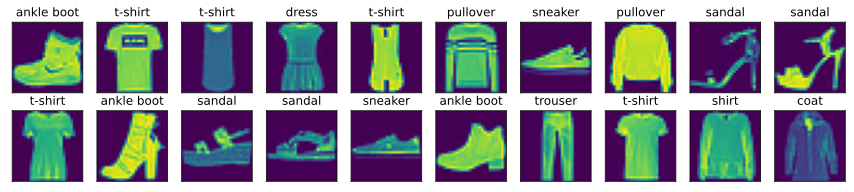

In [515]:
# displaying what the images look like
X, y = next(iter(data.DataLoader(mnist_train, batch_size=20)))
mu.show_images(X.reshape(20, 28, 28), 2, 10, titles=mu.get_fashion_mnist_labels(y))
plt.show()

In [516]:
# loading in the data in batches
# batch_size set to a number which is a factor of 60,000 and 10,000 to avoid overlapping
batch_size = 250
train_iter, test_iter = mu.load_data_fashion_mnist(batch_size)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [517]:
X, y = next(iter(train_iter)) # first batch
print(X.size())
print(y.size())

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([250, 1, 28, 28])
torch.Size([250])


In [518]:
# printing the length of each batch
print('Training data length: ',len(train_iter))
print('Testing data length: ',len(test_iter))

Training data length:  240
Testing data length:  40


### Building patches function

Image tensor shape before squeeze:  torch.Size([1, 28, 28])
Image tensor after squeeze:  torch.Size([28, 28])


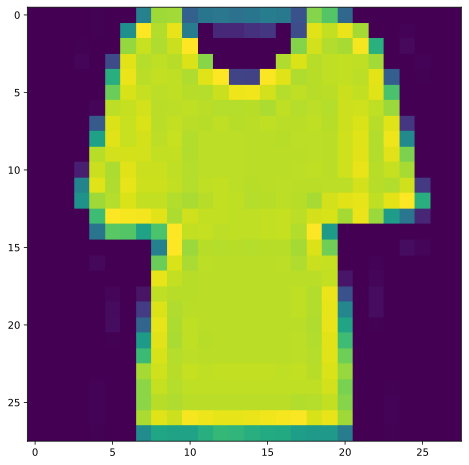

In [519]:
# an example of an image in the dataset
img = X[0]
print('Image tensor shape before squeeze: ',img.shape)
x = img.squeeze(dim=0)
print('Image tensor after squeeze: ',x.shape)
# print image
fig = plt.figure(figsize=(8,8))
plt.imshow(x)

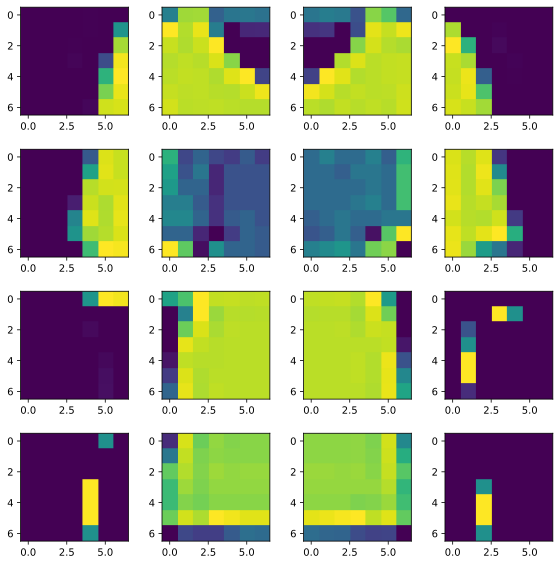

In [520]:
# Example of splitting an images into patches
img = X[0]

# size of each patch (pixels) height and width
patch_size = 7

# no. of patches
patch_number = (28 // patch_size) ** 2

# Convert the image into patches
patches = img.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size)
patch = patches[0].reshape([-1, 7, 7])

# plotting the image as patches
fig = plt.figure(figsize=(8,8));

columns = 28//patch_size;
rows = 28//patch_size;
for i in range(len(patch)):
    fig.add_subplot(rows, columns, i+1)
    fig.tight_layout()
    plt.imshow(patch[i].cpu())
plt.show()

In [521]:
# function splits the image up into evenly sized non-overlapping patches
def patches(input_image, patch_size): 

  # Calculates number of patches for a single image
  patch_number = (28 // patch_size) ** 2
  # Converts the image into patches
  patches = input_image.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size)
  # Vectorizes patches
  patches = patches.reshape([input_image.size(dim=0), patch_number, patch_size**2])

  return patches


### The model

In [522]:
class Net(torch.nn.Module):
 
    def __init__(self, patch_size, num_inputs, num_hidden, num_outputs):
        super(Net, self).__init__()
        # assigns the patch size, num_inputs, num_hidden, and num_outputs variables respectively
        self.patch_size = patch_size
        self.num_inputs = num_inputs
        self.num_hidden = num_hidden
        self.num_outputs = num_outputs

        # defining the linear transformations 
        self.lin1 = nn.Linear(num_inputs, num_hidden[0]) # lin for stem
        self.lin2 = nn.Linear(num_hidden[1], num_hidden[2]) # lin for backbone 
        self.lin3 = nn.Linear(num_hidden[2], num_hidden[3])
        self.lin4 = nn.Linear(num_hidden[4], num_hidden[5])
        self.lin5 = nn.Linear(num_hidden[5], num_outputs) # lin for classifying 
        self.relu = nn.ReLU() # rectified linear unit
        self.dropout = nn.Dropout(0.1) # dropout 
        
    def forward(self, x):  # Initial shape [250, 1, 28, 28]
        # STEM
        x = torch.squeeze(x, 1)   # Flattens image input to a shape of[250, 28, 28]
        x = patches(x, self.patch_size) # splits batches of images to [250, 196, 4]
        x = self.lin1(x) # applies linear transformation to [196, 392] feature vector
        x = self.relu(x) # relu activation function
        x = torch.transpose(x,1,2) # ouput of the stem must be transposed before backbone therefore [392, 196]
        
        # BACKBONE
        x = self.lin2(x) # linear transform to a 392x90 matrix
        x = self.relu(x) # apply relu
        x = self.dropout(x) # add dropout
        x = self.lin3(x) # linear transform to [392, 45]
        x = self.relu(x)
        x = torch.transpose(x,1,2) # tranposes matrix to [45, 392]
        x = self.lin4(x) 
        x = self.dropout(x) # adding a dropout
        x = torch.mean(x, 2)

        # CLASSIFIER
        output = self.lin5(x) # input of 45, output of 10
        return output
 

# Defining parameters
patch_size = 2 # patch_size = 2 means image will be split into 196 2x2pixel images
num_inputs = patch_size**2  # K x K inputs 
num_hidden = [392, 196, 90, 45, 392, 45]  
num_outputs = 10 # classifying 10 classes
net = Net(patch_size, num_inputs, num_hidden, num_outputs)

In [523]:
# function taken from Week05 lab
# function to initialize the weights of the the linear layers and bias
def init_weights(m):
    if isinstance(m, nn.Linear): # by checking the type we can init different layers in different ways
        torch.nn.init.normal_(m.weight, std=0.01)
        torch.nn.init.zeros_(m.bias)

# applies weights to the net
net.apply(init_weights);
print(net)

Net(
  (lin1): Linear(in_features=4, out_features=392, bias=True)
  (lin2): Linear(in_features=196, out_features=90, bias=True)
  (lin3): Linear(in_features=90, out_features=45, bias=True)
  (lin4): Linear(in_features=392, out_features=45, bias=True)
  (lin5): Linear(in_features=45, out_features=10, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
)


In [524]:
lr = 0.001    # Learning Rate
wd = 0        # Weight Decay

# Softmax-Cross Entropy loss to calculates the difference between the output and the target variable 
loss = nn.CrossEntropyLoss()

# Minibatch Stochastic Gradient Descent
# optimizer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd)
optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=wd)

### Evaluation

In [525]:
# Class and Functions taken from Week05 lab
# Accuracy function to compute the number of correct predictions
def accuracy(y_hat, y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)         
    cmp = (y_hat.type(y.dtype) == y)  
    return float(torch.sum(cmp)) # Taking the sum yields the number of correct predictions.

In [526]:
# Class and Functions taken from Week05 lab
class Accumulator:  
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
    def reset(self):
        self.data = [0.0] * len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

In [527]:
# Function taken from Week05 lab
# Compute the accuracy for a model on a dataset
def evaluate_accuracy(net, data_iter): 
    metric = Accumulator(2)
    for _, (X, y) in enumerate(data_iter):
      metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [528]:
# Class and Functions taken from Week05 lab
# Creating Animator Class for Display
class Animator: 
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(5.5, 4.5)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        mu.use_svg_display()
        self.fig, self.axes = mu.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: mu.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)
        display.display(self.fig)
        display.clear_output(wait=True)

### Training Model

In [529]:
# Function taken from Week05 lab
# The training function for one epoch
def train_epoch_ch3(net, train_iter, loss, optimizer, batch_size=250, num_outputs=10):  
    # Set the model to training mode
    if isinstance(net, torch.nn.Module):
        net.train()
    # Sum of training loss, sum of training accuracy, no. of examples
    metric = Accumulator(3)
    for X, y in train_iter:
        # Compute gradients and update parameters
        y_hat = net(X)
        l = loss(y_hat, y)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        metric.add(float(l) * len(y), accuracy(y_hat, y), y.size().numel())
    # Return training loss and training accuracy
    return metric[0] / metric[2], metric[1] / metric[2]

In [530]:
# Function taken from Week05 lab
def train_ch3(net, train_iter, test_iter, loss, num_epochs, optimizer): 
    animator = Animator(xlabel='epoch', xlim=[0, num_epochs], ylim=[0.0, 1.0],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, optimizer)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

Training loss: 0.3045817914729317
Training accuracy: 0.8881
Testing accuracy: 0.8721


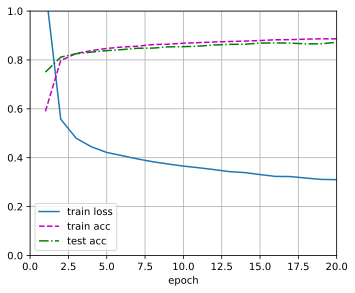

In [531]:
# train the model
num_epochs = 20
train_ch3(net, train_iter, test_iter, loss, num_epochs, optimizer)

# collects the train and testing metrics using 'train_epoch_ch3' and 'evaluate_accuracy' functions
train_metrics = train_epoch_ch3(net, train_iter, loss ,optimizer)
test_metrics = evaluate_accuracy(net, test_iter)
# prints metrics
print('Training loss: {}'.format(train_metrics[0]))
print('Training accuracy: {}'.format(train_metrics[1]))
print('Testing accuracy: {}'.format(test_metrics))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


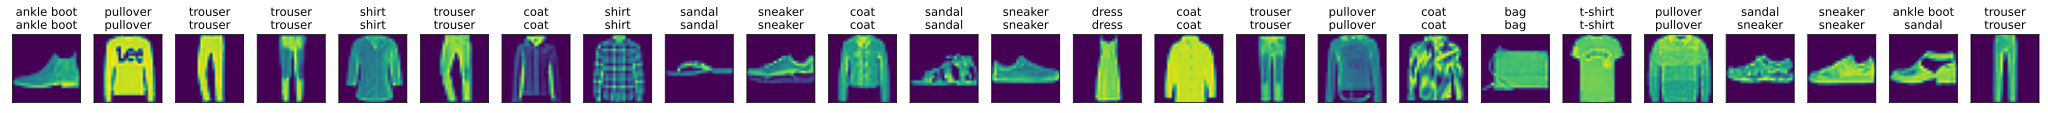

In [532]:
# Code used from Dive into Deep Learning, Chapter 3, Pg 124
# Compare ground truth labels (first line of text output) and the predictions from the model (second line of text output)
def predict_ch3(model, test_iter, n=25):  
    for X, y in test_iter:
        break
    trues = mu.get_fashion_mnist_labels(y)
    preds = mu.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    mu.show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)